# Decision tree

https://en.wikipedia.org/wiki/Decision_tree_learning

In [7]:
from sklearn.datasets import make_blobs, make_moons
import numpy as np
import pandas as pd
import random as rnd
import matplotlib.pyplot as plt
import matplotlib as mp

#### Gini, entropy, gain

In [8]:
def gini(x):
    gini = 1
    size = len(x)
    labels = {l:0 for l in set(list(x))}
    for item in x:
        labels[item] += 1
        
    for l, cnt in labels.items():
        gini -= (cnt / size) ** 2
        
    return gini
    
    
def entropy(x):
    entropy = 0
    size = len(x)
    labels = {l:0 for l in set(list(x))}
    for item in x:
        labels[item] += 1
        
    for l, cnt in labels.items():
        entropy += (cnt / size * np.log2(cnt / size))
    
    return -entropy
        

def gain(left_y, right_y, criterion):
    node = np.concatenate((left_y, right_y), axis=0)
    node_len = len(left_y) + len(right_y)
    ig = criterion(node) * node_len - (len(left_y) * criterion(left_y) + len(right_y) * criterion(right_y))
    return ig

## DecisionTreeClassifier

In [9]:
class DecisionTreeLeaf:
    def __init__(self, y=None):
        self.y = None
        self.prob = 0
        if y is not None:
            max_c = 0
            max_y = None
            tmp = {i.item(): 0 for i in y}
            for i in y:
                tmp[i.item()] += 1
            for k, v in tmp.items():
                if v > max_c:
                    max_c = v
                    max_y = k

            self.prob = max_c / len(y)
            self.y = max_y

class DecisionTreeNode:
    def __init__(self, split_dim=None, split_value=None, left=None, right=None):
        self.split_dim = split_dim
        self.split_value = split_value
        self.left = left
        self.right = right

In [10]:
class DecisionTreeClassifier:
    def __init__(self, criterion="gini", max_depth=None, min_samples_leaf=1):
        self.root = None
        self.max_depth = max_depth
        self.leaf_size = min_samples_leaf
        if criterion == 'gini':
            self.criterion = gini
        if criterion == 'entropy':
            self.criterion = entropy

    def best_partition(self, X, y):
        feature_cnt = X.shape[1]
        sample_size = len(X)
        max_ig = 0
        delimiter = 0
        dimension = 0
        val = 0
        for i in range(0, feature_cnt):
            p = X[:, i].argsort()
            X = X[p]
            y = y[p]

            for j in range(0, sample_size + 1):
                left_y = y[:j]
                right_y = y[j:]
                ig = gain(left_y, right_y, self.criterion)
                if ig > max_ig:
                    max_ig = ig
                    delimiter = j
                    dimension = i

        p = X[:, dimension].argsort()
        X = X[p]
        y = y[p]

        x_left = X[:delimiter]
        x_right = X[delimiter:]
        y_left = y[:delimiter]
        y_right = y[delimiter:]

        return x_left, y_left, x_right, y_right, dimension, X[delimiter, dimension]

    def tree_builder(self, lvl, X, y):
        if (self.leaf_size is not None and X.size <= self.leaf_size) or \
                (self.max_depth is not None and lvl == self.max_depth):
            return DecisionTreeLeaf(y)

        x_left, y_left, x_right, y_right, dim, val = DecisionTreeClassifier.best_partition(self, X, y)

        if y_left.size != 0 and y_right.size == 0:
            return DecisionTreeLeaf(y_left)
        elif y_left.size == 0 and y_right.size != 0:
            return DecisionTreeLeaf(y_right)

        node = DecisionTreeNode(split_dim=dim, split_value=val)
        node.left = DecisionTreeClassifier.tree_builder(self, lvl + 1, x_left, y_left)
        node.right = DecisionTreeClassifier.tree_builder(self, lvl + 1, x_right, y_right)

        return node

    def fit(self, X, y):
        self.root = DecisionTreeClassifier.tree_builder(self, 0, X, y)

    def predict_proba(self, X):
        probs = []
        for i in range(0, len(X)):
            curr_node = self.root
            while curr_node is not None and not isinstance(curr_node, DecisionTreeLeaf):
                if X[i, curr_node.split_dim] < curr_node.split_value:
                    curr_node = curr_node.left
                else:
                    curr_node = curr_node.right
            probs.append({curr_node.y:curr_node.prob})

        return probs

    def predict(self, X):
        proba = self.predict_proba(X)
        return [max(p.keys(), key=lambda k: p[k]) for p in proba]

### draw tree

In [5]:
def tree_depth(tree_root):
    if isinstance(tree_root, DecisionTreeNode):
        return max(tree_depth(tree_root.left), tree_depth(tree_root.right)) + 1
    else:
        return 1

def draw_tree_rec(tree_root, x_left, x_right, y):
    x_center = (x_right - x_left) / 2 + x_left
    if isinstance(tree_root, DecisionTreeNode):
        x_center = (x_right - x_left) / 2 + x_left
        x = draw_tree_rec(tree_root.left, x_left, x_center, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        x = draw_tree_rec(tree_root.right, x_center, x_right, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        plt.text(x_center, y, "x[%i] < %f" % (tree_root.split_dim, tree_root.split_value),
                horizontalalignment='center')
    else:
        plt.text(x_center, y, str(tree_root.y),
                horizontalalignment='center')
    return x_center

def draw_tree(tree, save_path=None):
    td = tree_depth(tree.root)
    plt.figure(figsize=(0.33 * 2 ** td, 2 * td))
    plt.xlim(-1, 1)
    plt.ylim(0.95, td + 0.05)
    plt.axis('off')
    draw_tree_rec(tree.root, -1, 1, td)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

In [6]:
def plot_roc_curve(y_test, p_pred):
    positive_samples = sum(1 for y in y_test if y == 0)
    tpr = []
    fpr = []
    for w in np.arange(-0.01, 1.02, 0.01):
        y_pred = [(0 if p.get(0, 0) > w else 1) for p in p_pred]
        tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
        fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
    plt.figure(figsize = (7, 7))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

def rectangle_bounds(bounds):
    return ((bounds[0][0], bounds[0][0], bounds[0][1], bounds[0][1]), 
            (bounds[1][0], bounds[1][1], bounds[1][1], bounds[1][0]))

def plot_2d_tree(tree_root, bounds, colors):
    if isinstance(tree_root, DecisionTreeNode):
        if tree_root.split_dim:
            plot_2d_tree(tree_root.left, [bounds[0], [bounds[1][0], tree_root.split_value]], colors)
            plot_2d_tree(tree_root.right, [bounds[0], [tree_root.split_value, bounds[1][1]]], colors)
            plt.plot(bounds[0], (tree_root.split_value, tree_root.split_value), c=(0, 0, 0))
        else:
            plot_2d_tree(tree_root.left, [[bounds[0][0], tree_root.split_value], bounds[1]], colors)
            plot_2d_tree(tree_root.right, [[tree_root.split_value, bounds[0][1]], bounds[1]], colors)
            plt.plot((tree_root.split_value, tree_root.split_value), bounds[1], c=(0, 0, 0))
    else:
        x, y = rectangle_bounds(bounds)
        plt.fill(x, y, c=colors[tree_root.y] + [0.2])

def plot_2d(tree, X, y):
    plt.figure(figsize=(9, 9))
    colors = dict((c, list(np.random.random(3))) for c in np.unique(y))
    bounds = list(zip(np.min(X, axis=0), np.max(X, axis=0)))
    plt.xlim(*bounds[0])
    plt.ylim(*bounds[1])
    plot_2d_tree(tree.root, list(zip(np.min(X, axis=0), np.max(X, axis=0))), colors)
    for c in np.unique(y):
        plt.scatter(X[y==c, 0], X[y==c, 1], c=[colors[c]], label=c)
    plt.legend()
    plt.tight_layout()
    plt.show()

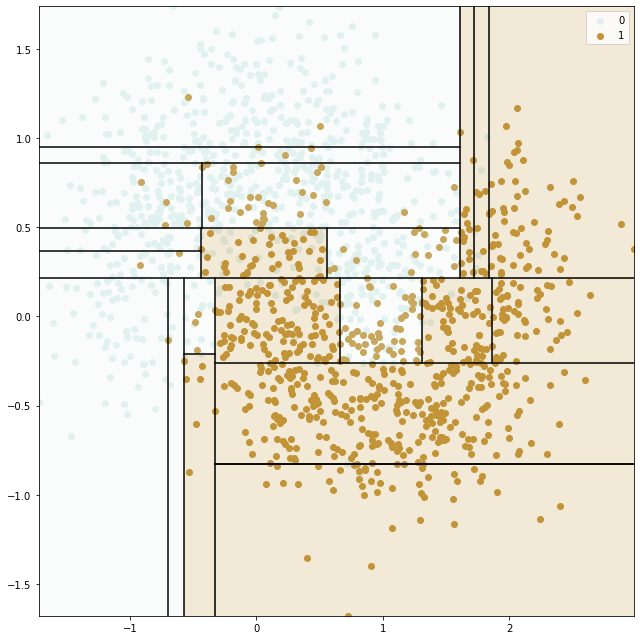

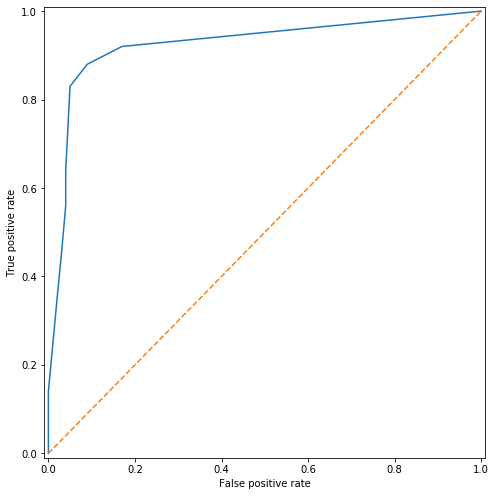

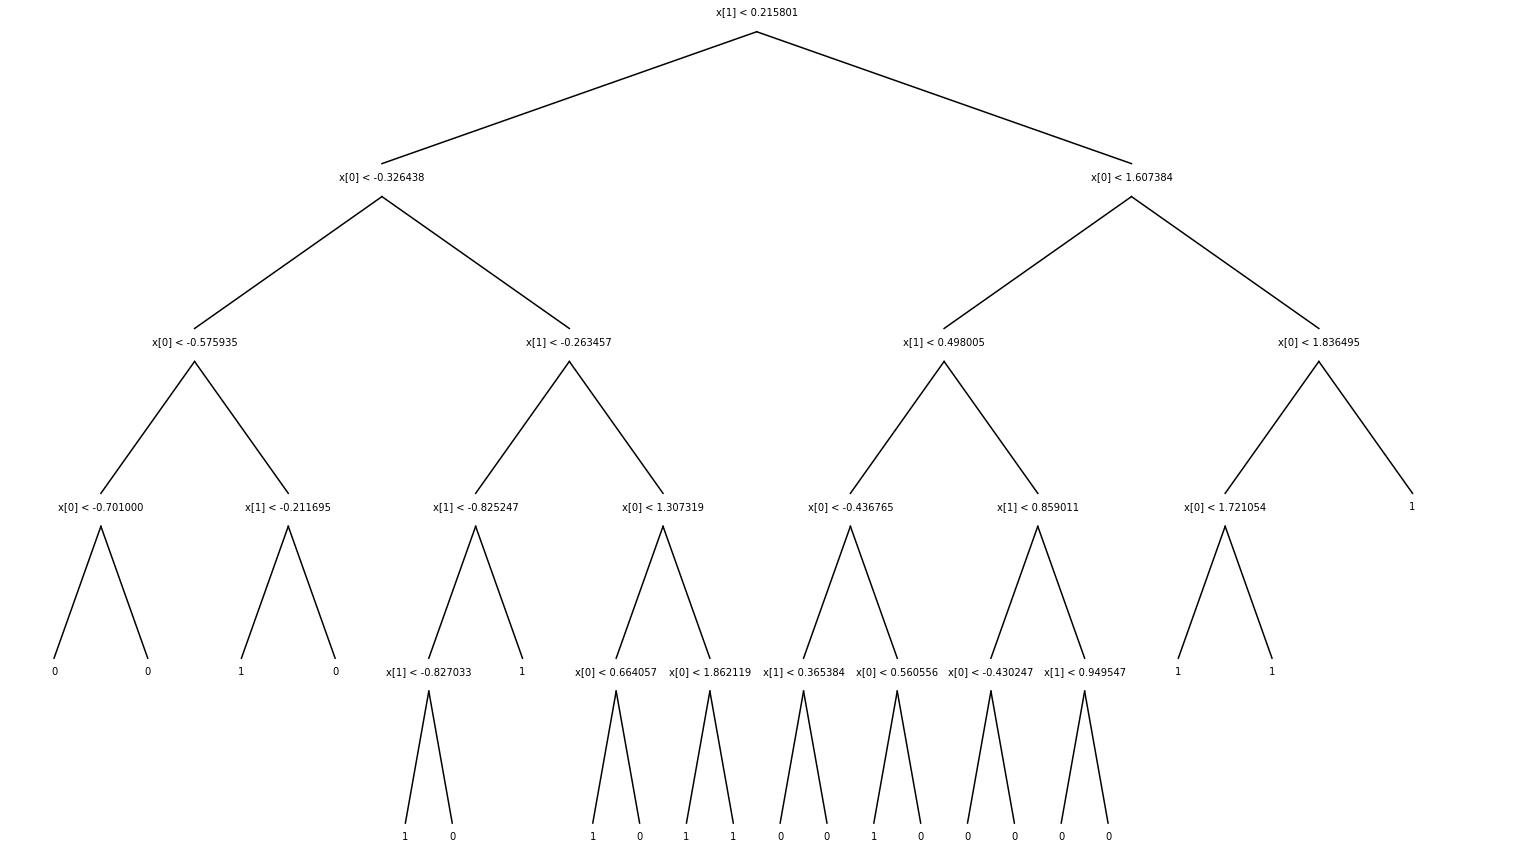

In [7]:
noise = 0.35
X, y = make_moons(1500, noise=noise)
X_test, y_test = make_moons(200, noise=noise)
tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=30)
tree.fit(X, y)
plot_2d(tree, X, y)
plot_roc_curve(y_test, tree.predict_proba(X_test))
draw_tree(tree)

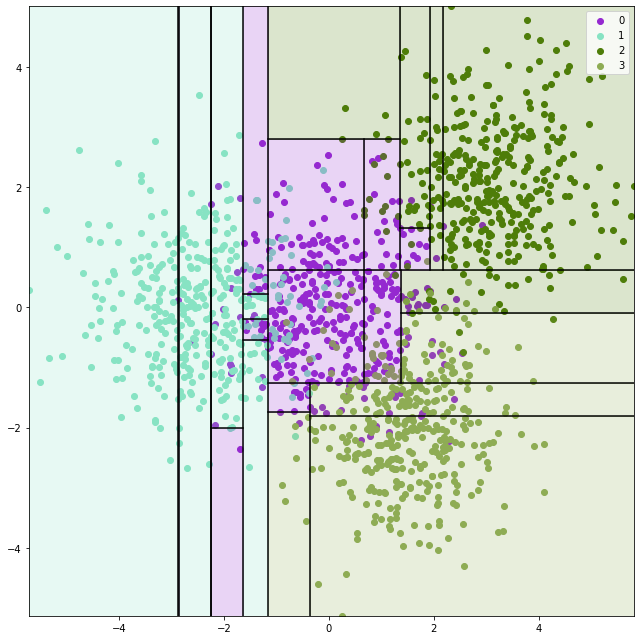

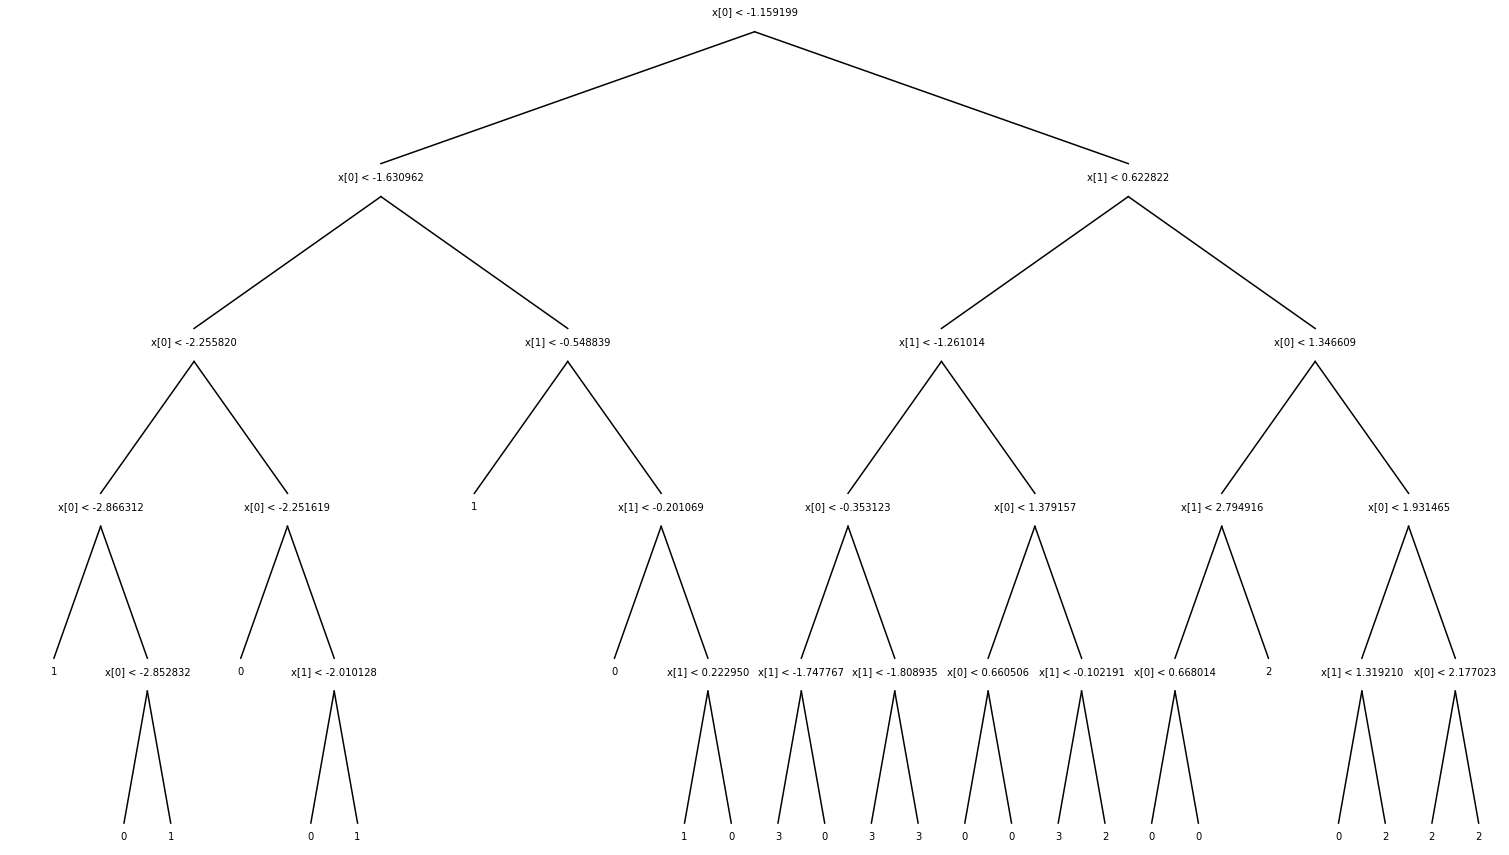

In [8]:
X, y = make_blobs(1500, 2, centers=[[0, 0], [-2.5, 0], [3, 2], [1.5, -2.0]])
tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=30)
tree.fit(X, y)
plot_2d(tree, X, y)
draw_tree(tree)

### Decisions explanation

In [12]:
def predict_explain(dtc, X):
    probs = []
    for i in range(0, len(X)):
        curr_node = dtc.root
        expl = f'{i}th element\n'
        j = 0
        while curr_node is not None and not isinstance(curr_node, DecisionTreeLeaf):
            if X[i, curr_node.split_dim] < curr_node.split_value:
                expl += f'value {round(X[i, curr_node.split_dim], 2)} on axis {curr_node.split_dim} < curr split value {round(curr_node.split_value,2)} on tree lvl {j}\n'
                curr_node = curr_node.left
            else:
                expl += f'value {round(X[i, curr_node.split_dim], 2)} on axis {curr_node.split_dim} >= curr split value {round(curr_node.split_value,2)} on tree lvl {j}\n'
                curr_node = curr_node.right
            j+=1
        probs.append((curr_node.y, expl))

    return probs

In [13]:
X, y = read_dataset("train.csv")
for pred_y, expl in predict_explain(dtc, X[:20]):
    print("Class:", pred_y)
    print("Explanation:", expl)
    print()

Class: rogue
Explanation: 0th element
value 0.29 on axis 1 < curr split value 0.35 on tree lvl 0
value 0.93 on axis 2 >= curr split value 0.64 on tree lvl 1
value 0.42 on axis 3 >= curr split value 0.42 on tree lvl 2
value 0.93 on axis 2 >= curr split value 0.8 on tree lvl 3
value 1.66 on axis 0 >= curr split value 0.56 on tree lvl 4
value 0.93 on axis 2 < curr split value 2.61 on tree lvl 5


Class: rogue
Explanation: 1th element
value 1.0 on axis 1 >= curr split value 0.35 on tree lvl 0
value 1.0 on axis 1 >= curr split value 0.92 on tree lvl 1


Class: rogue
Explanation: 2th element
value 0.92 on axis 1 >= curr split value 0.35 on tree lvl 0
value 0.92 on axis 1 >= curr split value 0.92 on tree lvl 1


Class: warrior
Explanation: 3th element
value 0.9 on axis 1 >= curr split value 0.35 on tree lvl 0
value 0.9 on axis 1 < curr split value 0.92 on tree lvl 1
value 0.8 on axis 3 < curr split value 0.82 on tree lvl 2
value 1.53 on axis 2 < curr split value 3.74 on tree lvl 3
value 2.52 